In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random

In [2]:
# TEMPLATE TO RUN GILLESPIE SIMULATION OF MODEL

# Helper functions (Do not change!)

def find_index_from_time(t_obs,time,start_index=0):  
    # loop through t_obs array from i=0  
    # stopping when t_obs[i+1] is greater than time  
    # so that t_obs[i] < time < t_obs[i+1]  
    # return i 
    i=start_index
    while i+1<len(t_obs):  
        if t_obs[i+1]>time:
            break
        i=i+1
    # i now stores index corresponding to system at time requested  
    return i 
      
def resample_observations(t_obs_in, s_obs_in, t_obs_out):
    s_obs_out=[] 
    pos=0 
    for time in t_obs_out:  
        i=find_index_from_time(t_obs_in,time, start_index=pos)
        si = s_obs_in[i]  
        s_obs_out.append(si) 
        pos = i
    return s_obs_out


def gen_next_event_time(rate):
    t=random.expovariate(rate)
    return t

def random_choice_from_pdf(pdf):
    cdf=[]
    cumulative_p=0
    for p in pdf:
        cumulative_p+=p
        cdf.append(cumulative_p)
    rand=random.random()

    for i in range(len(cdf)):
        if rand<cdf[i]:
            return i
    # last cdf should be 1.0 so the following should never happen!
    print("Error generating choice, check PDF")
    return None


In [3]:
# TEMPLATE TO RUN GILLESPIE SIMULATION OF MODEL

def gillespie_toggle(s,t_obs_out,params):

    #--0--# Unpack parameters and species variables

    km0L, kmL, KL, nL, kdmL, kpL, kdpL, km0T, kmT, KT, nT, kdmT, kpT, kdpT = params
    
    ML, PL, MT, PT = s0

    #--0--#

    # create arrays for output
    s_obs=[]
    t_obs=[]

    # read in start time and end time
    t_init=t_obs_out[0]
    t_final=t_obs_out[-1]

    t=t_init
    t_obs.append(t)
    s_obs.append(s0)

    while t < t_final:

        #--1--# Write labels for each event type here.

        types = ["ML_Prod", "ML_Loss","PL_Prod","PL_Loss","MT_Prod","MT_Loss","PT_Prod","PT_Loss"]

        #--1--#


        #--2--# Write rate expressions for each of the events
        rate_ML_prod = km0L + kmL*(KT**nT/(PT**nT+KT**nT))
        rate_ML_loss = kdmL*ML

        rate_PL_prod =  kpL*ML
        rate_PL_loss =  kdpL*PL

        rate_MT_prod = km0T + kmT*(KL**nL/(PL**nL+KL**nL))
        rate_MT_loss = kdmT*MT

        rate_PT_prod = kpT*MT
        rate_PT_loss = kdpT*PT
        
        
        

        #--2--#



        #--3--# Store the rates into a list preserving the order of step 1.

        rates = [rate_ML_prod, rate_ML_loss, rate_PL_prod, rate_PL_loss, rate_MT_prod, rate_MT_loss, rate_PT_prod, rate_PT_loss]

        #--3--#


        #-- Do not edit the section below --#

        ## CARRY OUT GILLESPIE ALGORITHM TO STEP FORWARD TO NEXT EVENT
        ## AND UPDATE SYSTEM STATE ACCORDING TO EVENT TYPE

        # calc total reaction rate
        rate_all_events=sum(rates)

        # if rate of events is zero break from loop
        # e.g. when all reactants used up
        if rate_all_events==0:
            break

        # generate the time until the next event
        # in accordance with rate_all_events
        next_event= gen_next_event_time(rate_all_events)

        # calc PDF for event type
        # in accordance with relative rates
        pdf=[]
        for event_rate in rates:
            p_event = event_rate/sum(rates)
            pdf.append(p_event)

        rand_i =  random_choice_from_pdf(pdf)
        event_type=types[rand_i]

        # increment time and number of molecules
        # according to event type
        t=t+next_event

        #-----------------------------------#



        ## ALGORITHM HAS INCREMENTED TIME AND SELECTED NEXT EVENT
        ## WE NOW NEED TO UPDATE OUR SYSTEM ACCORDING TO THE EVENT
        ## TYPE STORED IN VARIABLE event_type


        #--4--# Complete the if-elif-else commands to update the system
              # according to event type

        if event_type == "ML_Prod":
            ML = ML + 1  # ML production event
        elif event_type == "ML_Loss":
            ML = ML - 1  # ML degradation event
        elif event_type == "PL_Prod":
            PL = PL + 1  # PL production event
        elif event_type == "PL_Loss":
            PL = PL - 1  # PL degradation event
        elif event_type == "MT_Prod":
            MT = MT + 1  # MT production event
        elif event_type == "MT_Loss":
            MT = MT - 1  # MT degradation event
        elif event_type == "PT_Prod":
            PT = PT + 1  # PT production event
        elif event_type == "PT_Loss":
            PT = PT - 1
        else:
            print("error unknown event type!!")

        #--4--#

        # store observation
        s=[ML, PL, MT, PT]

        t_obs.append(t)
        s_obs.append(s)

        # loops until time t exceeds t_final

    # loop has ended

    # before we return the results we must
    # resample the output to provide observations in accordance
    # with the t_obs passed to the function
    s_obs = resample_observations(t_obs,s_obs,t_obs_out)
    s_obs = np.array(s_obs)
    return (s_obs, t_obs_out)

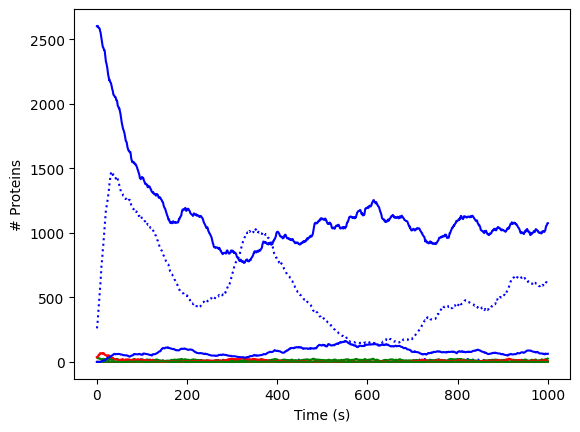

In [4]:
# EXAMPLE CODE TO SIMULATE A SINGLE RUN

# define parameter values
km0L = 0.032
kmL = 8.3
KL = 31.94
nL = 2
kdmL = 0.1386 
kpL = 0.9726
kdpL = 0.0165

km0T = 0.119
kmT = 2.06
KT = 30
nT = 2
kdmT = 0.1386 
kpT = 1.170
kdpT = 0.0165

params = (km0L, kmL, KL, nL, kdmL, kpL, kdpL,
          km0T, kmT, KT, nT, kdmT, kpT, kdpT)

# define initial conditions
ML0 = 0
PL0 = 0
MT0 = 36
PT0 = 2600

s0 = (ML0, PL0, MT0, PT0)

# define time observation points
t_start = 0
t_end = 1000

t_obs = np.arange(t_start, t_end+0.1, 1)

# run simulation
s_obs, t_obs = gillespie_toggle(s0, t_obs, params)

ML0 = 36
PL0 = 2600
MT0 = 0
PT0 = 0

s0 = (ML0, PL0, MT0, PT0)

s_obs1, t_obs = gillespie_toggle(s0, t_obs, params)

# extract the observations
ML_obs = s_obs[:,0]
PL_obs = s_obs[:,1]
MT_obs = s_obs[:,2]
PT_obs = s_obs[:,3]

ML_obsL = s_obs1[:,0]
PL_obsL = s_obs1[:,1]
MT_obsL = s_obs1[:,2]
PT_obsL = s_obs1[:,3]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(t_obs, ML_obs, 'r-')
ax.plot(t_obs, PL_obs, 'b:')
ax.plot(t_obs, MT_obs, 'g-')
ax.plot(t_obs, PT_obs, 'b-')

ax.plot(t_obs, ML_obsL, 'r-')
ax.plot(t_obs, PL_obsL, 'b:')
ax.plot(t_obs, MT_obsL, 'g-')
ax.plot(t_obs, PT_obsL, 'b-')


ax.set_ylabel("# Proteins")
ax.set_xlabel("Time (s)");

Text(0.5, 1.0, 'Stochastic simulation of TetR')

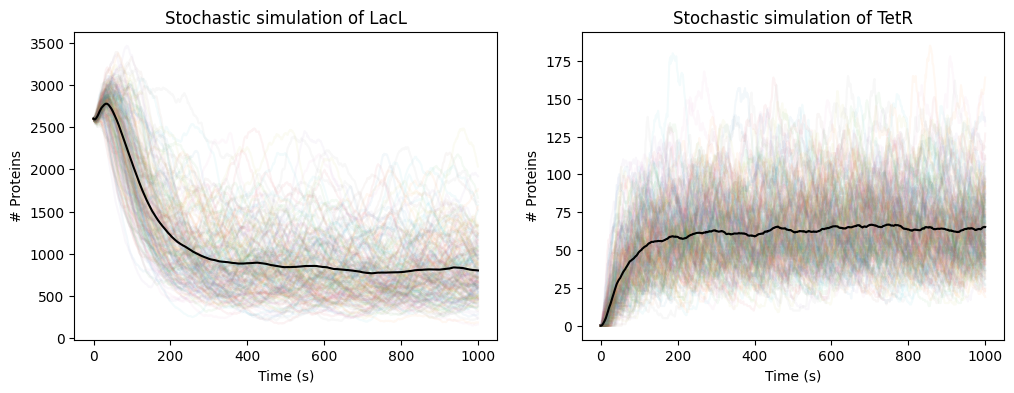

In [18]:
def sdot2(s,t,params):
    ML, PL, MT, PT = s
    km0L, kmL, KL, nL, kdmL, kpL, kdpL, km0T, kmT, KT, nT, kdmT, kpT, kdpT = params

    rate_ML_prod = km0L + kmL*(KT**nT/(PT**nT+KT**nT))
    rate_ML_loss = kdmL*ML

    rate_PL_prod =  kpL*ML
    rate_PL_loss =  kdpL*PL

    rate_MT_prod = km0T + kmT*(KL**nL/(PL**nL+KL**nL))
    rate_MT_loss = kdmT*MT

    rate_PT_prod = kpT*MT
    rate_PT_loss = kdpT*PT
        
    dML = rate_ML_prod - rate_ML_loss
    dPL = rate_PL_prod - rate_PL_loss
    
    dMT = rate_MT_prod - rate_MT_loss
    dPT = rate_PT_prod - rate_PT_loss
    
    ds = [dML, dPL, dMT, dPT]
    return ds

# define list of observation points 't_obs'
t_start = 0
t_end = 1000
t_obs = np.arange(t_start, t_end+0.1, 1)
# define initial conditions
ML0 = 36
PL0 = 2600
MT0 = 0
PT0 = 0

s0 = (ML0, PL0, MT0, PT0)

# define parameter values
km0L = 0.032
kmL = 8.3
KL = 31.94
nL = 2
kdmL = 0.1386 
kpL = 0.9726
kdpL = 0.0165

km0T = 0.119
kmT = 2.06
KT = 30
nT = 2
kdmT = 0.1386 
kpT = 1.170
kdpT = 0.0165

params = (km0L, kmL, KL, nL, kdmL, kpL, kdpL,
          km0T, kmT, KT, nT, kdmT, kpT, kdpT)

# run simulation and load results
s_obs = odeint(sdot2,s0,t_obs,args=(params,))  

ML_obs = s_obs[:,0]
PL_obs = s_obs[:,1]
MT_obs = s_obs[:,2]
PT_obs = s_obs[:,3]

fig1 = plt.figure(figsize=(12,4))
ML_runs = []
PL_runs = []
MT_runs = []
PT_runs = []

for i in range(200):
    s_obs, t_obs = gillespie_toggle(s0, t_obs, params)
    ML_obs = s_obs[:,0]
    PL_obs = s_obs[:,1]
    MT_obs = s_obs[:,2]
    PT_obs = s_obs[:,3]

    ML_runs.append(ML_obs)
    PL_runs.append(PL_obs)
    MT_runs.append(MT_obs)
    PT_runs.append(PT_obs)

# convert to array
ML_runs = np.array(ML_runs)
PL_runs = np.array(PL_runs)
MT_runs = np.array(MT_runs)
PT_runs = np.array(PT_runs)

ax2=fig1.add_subplot(1,2,1)
ax2.plot(t_obs, PL_runs.T, alpha = 0.05)
ax2.plot(t_obs, np.average(PL_runs,axis=0),'k')

ax2.set_ylabel("# Proteins")
ax2.set_xlabel("Time (s)");
ax2.set_title("Stochastic simulation of LacL")


ax3=fig1.add_subplot(1,2,2)
ax3.plot(t_obs, PT_runs.T, alpha = 0.05)
ax3.plot(t_obs, np.average(PT_runs,axis=0),'k')

ax3.set_ylabel("# Proteins")
ax3.set_xlabel("Time (s)");
ax3.set_title("Stochastic simulation of TetR")

Text(0.5, 1.0, 'Stochastic simulation of TetR')

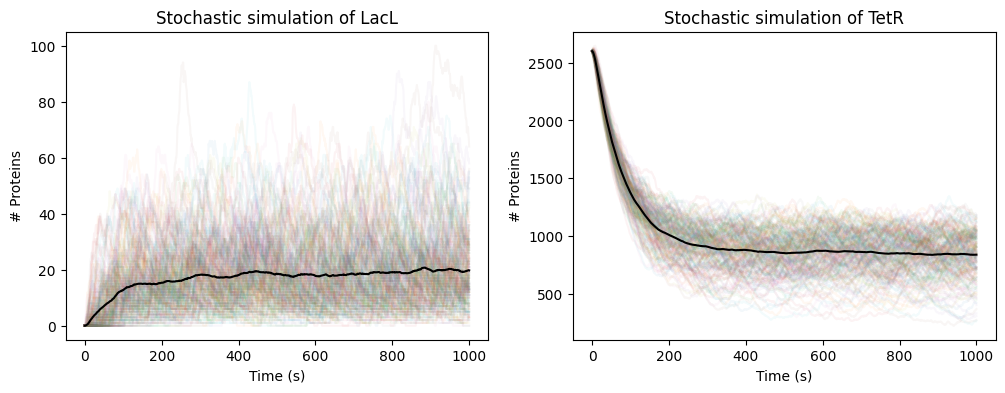

In [19]:
def sdot2(s,t,params):
    ML, PL, MT, PT = s
    km0L, kmL, KL, nL, kdmL, kpL, kdpL, km0T, kmT, KT, nT, kdmT, kpT, kdpT = params

    rate_ML_prod = km0L + kmL*(KT**nT/(PT**nT+KT**nT))
    rate_ML_loss = kdmL*ML

    rate_PL_prod =  kpL*ML
    rate_PL_loss =  kdpL*PL

    rate_MT_prod = km0T + kmT*(KL**nL/(PL**nL+KL**nL))
    rate_MT_loss = kdmT*MT

    rate_PT_prod = kpT*MT
    rate_PT_loss = kdpT*PT
        
    dML = rate_ML_prod - rate_ML_loss
    dPL = rate_PL_prod - rate_PL_loss
    
    dMT = rate_MT_prod - rate_MT_loss
    dPT = rate_PT_prod - rate_PT_loss
    
    ds = [dML, dPL, dMT, dPT]
    return ds

# define list of observation points 't_obs'
t_start = 0
t_end = 1000
t_obs = np.arange(t_start, t_end+0.1, 1)

# define initial conditions
ML0 = 0
PL0 = 0
MT0 = 36
PT0 = 2600

s0 = (ML0, PL0, MT0, PT0)

# define parameter values
km0L = 0.032
kmL = 8.3
KL = 31.94
nL = 2
kdmL = 0.1386 
kpL = 0.9726
kdpL = 0.0165

km0T = 0.119
kmT = 2.06
KT = 30
nT = 2
kdmT = 0.1386 
kpT = 1.170
kdpT = 0.0165

params = (km0L, kmL, KL, nL, kdmL, kpL, kdpL,
          km0T, kmT, KT, nT, kdmT, kpT, kdpT)

# run simulation and load results
s_obs = odeint(sdot2,s0,t_obs,args=(params,))  

ML_obs = s_obs[:,0]
PL_obs = s_obs[:,1]
MT_obs = s_obs[:,2]
PT_obs = s_obs[:,3]

fig1 = plt.figure(figsize=(12,4))
ML_runs = []
PL_runs = []
MT_runs = []
PT_runs = []

for i in range(200):
    s_obs, t_obs = gillespie_toggle(s0, t_obs, params)
    ML_obs = s_obs[:,0]
    PL_obs = s_obs[:,1]
    MT_obs = s_obs[:,2]
    PT_obs = s_obs[:,3]

    ML_runs.append(ML_obs)
    PL_runs.append(PL_obs)
    MT_runs.append(MT_obs)
    PT_runs.append(PT_obs)

# convert to array
ML_runs = np.array(ML_runs)
PL_runs = np.array(PL_runs)
MT_runs = np.array(MT_runs)
PT_runs = np.array(PT_runs)

ax2=fig1.add_subplot(1,2,1)
ax2.plot(t_obs, PL_runs.T, alpha = 0.05)
ax2.plot(t_obs, np.average(PL_runs,axis=0),'k')

ax2.set_ylabel("# Proteins")
ax2.set_xlabel("Time (s)");
ax2.set_title("Stochastic simulation of LacL")


ax3=fig1.add_subplot(1,2,2)
ax3.plot(t_obs, PT_runs.T, alpha = 0.05)
ax3.plot(t_obs, np.average(PT_runs,axis=0),'k')

ax3.set_ylabel("# Proteins")
ax3.set_xlabel("Time (s)");
ax3.set_title("Stochastic simulation of TetR")

Text(0, 0.5, 'frequency')

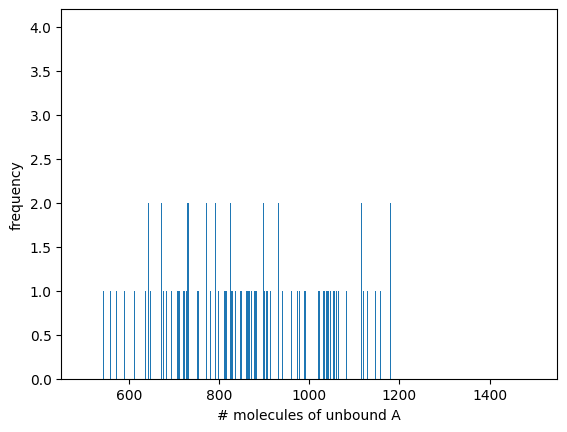

In [38]:
fig2 = plt.figure()
ax=fig2.add_subplot(1,1,1)
#  histogram all rows (runs) at end of simulation
lines = ax.hist(PT_runs[:,-1], bins=np.arange(500,1500.6,1.0))
ax.set_xlabel("# molecules of unbound A")
ax.set_ylabel("frequency")